In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d debeshjha1/kvasirseg -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/debeshjha1/kvasirseg
License(s): copyright-authors
 73% 106M/144M [00:00<00:00, 1.10GB/s]
100% 144M/144M [00:00<00:00, 619MB/s] 


In [ ]:
ROOT = "/content/Kvasir-SEG/Kvasir-SEG"
IMG_DIR = ROOT + "/images"
MASK_DIR = ROOT + "/masks"

import os, time, numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

# ---------------- CONFIG ----------------
IMG_SIZE = 192
BATCH_SIZE = 8
EPOCHS = 35
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 6
PRINT_EVERY = 1
THRESH = 0.5
print("DEVICE:", DEVICE)

DEVICE: cuda


In [ ]:
# ---------------- Dataset with shared augmentations ----------------
class KvasirAugDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=192, augment=False):
        self.size = size
        imgs = sorted([p for p in Path(img_dir).iterdir() if p.is_file()])
        masks = sorted([p for p in Path(mask_dir).iterdir() if p.is_file()])
        img_map = {p.stem:p for p in imgs}
        mask_map = {p.stem:p for p in masks}
        common = sorted(list(set(img_map.keys()) & set(mask_map.keys())))
        if len(common)==0:
            raise RuntimeError("No matching image/mask stems found.")
        self.pairs = [(str(img_map[s]), str(mask_map[s])) for s in common]
        self.augment = augment
        self.mean = [0.485, 0.456, 0.406]
        self.std  = [0.229, 0.224, 0.225]

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        img_p, mask_p = self.pairs[idx]
        img = Image.open(img_p).convert("RGB")
        mask = Image.open(mask_p).convert("L")

        if self.augment:
            if np.random.rand() < 0.5:
                img = TF.hflip(img); mask = TF.hflip(mask)
            angle = np.random.uniform(-15, 15)
            img = TF.rotate(img, angle)
            mask = TF.rotate(mask, angle)

        # resize
        img = TF.resize(img, (self.size, self.size), interpolation=Image.BILINEAR)
        mask = TF.resize(mask, (self.size, self.size), interpolation=Image.NEAREST)

        img_t = TF.to_tensor(img)
        img_t = TF.normalize(img_t, self.mean, self.std)

        mask_np = np.array(mask).astype(np.int32)
        if mask_np.max() > 1:
            mask_np = (mask_np > 0).astype(np.uint8)
        mask_t = torch.from_numpy(mask_np).unsqueeze(0).float()
        return img_t, mask_t

In [ ]:

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.enc1 = ConvBlock(3, base)        # 32
        self.enc2 = ConvBlock(base, base*2)   # 64
        self.enc3 = ConvBlock(base*2, base*4) # 128
        self.pool = nn.MaxPool2d(2)
        self.up3 = nn.ConvTranspose2d(base*4, base*2, 2,2)
        self.dec3 = ConvBlock(base*4, base*2)
        self.up2 = nn.ConvTranspose2d(base*2, base, 2,2)
        self.dec2 = ConvBlock(base*2, base)
        self.outc = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))

        u3 = self.up3(x3)
        if u3.shape[2:] != x2.shape[2:]:
            dy = x2.size(2)-u3.size(2); dx = x2.size(3)-u3.size(3)
            u3 = F.pad(u3, [dx//2, dx-dx//2, dy//2, dy-dy//2])
        d3 = self.dec3(torch.cat([u3, x2], dim=1))

        u2 = self.up2(d3)
        if u2.shape[2:] != x1.shape[2:]:
            dy = x1.size(2)-u2.size(2); dx = x1.size(3)-u2.size(3)
            u2 = F.pad(u2, [dx//2, dx-dx//2, dy//2, dy-dy//2])
        d2 = self.dec2(torch.cat([u2, x1], dim=1))

        out = self.outc(d2)
        return out

# ---------------- metrics & losses ----------------
def batch_dice_iou(preds, targets, eps=1e-7):
    B = preds.size(0)
    p = preds.view(B, -1); t = targets.view(B, -1)
    inter = (p*t).sum(1)
    union = (p + t - p*t).sum(1)
    denom = p.sum(1) + t.sum(1)
    valid = (union > 0)
    if valid.sum().item() == 0:
        return float('nan'), float('nan'), 0
    dice = ((2*inter + eps)/(denom + eps))[valid].mean().item()
    iou  = ((inter + eps)/(union + eps))[valid].mean().item()
    return dice, iou, int(valid.sum().item())

def dice_loss_logits(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    B = probs.size(0)
    p = probs.view(B,-1); t = targets.view(B,-1)
    inter = (p*t).sum(1); denom = p.sum(1)+t.sum(1)
    dice_per = (2*inter + eps)/(denom + eps)
    return 1.0 - dice_per.mean()

# ---------------- prepare data loaders ----------------
dataset = KvasirAugDataset(IMG_DIR, MASK_DIR, size=IMG_SIZE, augment=False)
print("Total pairs:", len(dataset))
n = len(dataset)
split = int(0.8 * n)
train_ds, val_ds = torch.utils.data.random_split(dataset, [split, n-split])
# enable augmentations for training subset
train_ds.dataset.augment = True

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if DEVICE.type=='cuda' else False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if DEVICE.type=='cuda' else False)

# ---------------- build model, optimizer, scheduler ----------------
model = UNet(base=32).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=3)
bce = nn.BCEWithLogitsLoss()


Total pairs: 1000


Epoch 1/35  train_loss=0.5736  val_loss=0.4102  Dice=0.2793  IoU=0.1843  valid=200
  -> saved best model (IoU=0.1843)
Epoch 2/35  train_loss=0.5373  val_loss=0.3771  Dice=0.4212  IoU=0.2974  valid=200
  -> saved best model (IoU=0.2974)
Epoch 3/35  train_loss=0.5163  val_loss=0.3798  Dice=0.4638  IoU=0.3400  valid=200
  -> saved best model (IoU=0.3400)
Epoch 4/35  train_loss=0.5028  val_loss=0.3366  Dice=0.3453  IoU=0.2354  valid=200
Epoch 5/35  train_loss=0.4908  val_loss=0.6049  Dice=0.4695  IoU=0.3469  valid=200
  -> saved best model (IoU=0.3469)
Epoch 6/35  train_loss=0.4767  val_loss=0.4127  Dice=0.4979  IoU=0.3664  valid=200
  -> saved best model (IoU=0.3664)
Epoch 7/35  train_loss=0.4774  val_loss=0.3205  Dice=0.4785  IoU=0.3483  valid=200
Epoch 8/35  train_loss=0.4620  val_loss=0.3245  Dice=0.4345  IoU=0.3136  valid=200
Epoch 9/35  train_loss=0.4569  val_loss=0.3181  Dice=0.5146  IoU=0.3888  valid=200
  -> saved best model (IoU=0.3888)
Epoch 10/35  train_loss=0.4460  val_loss=0.

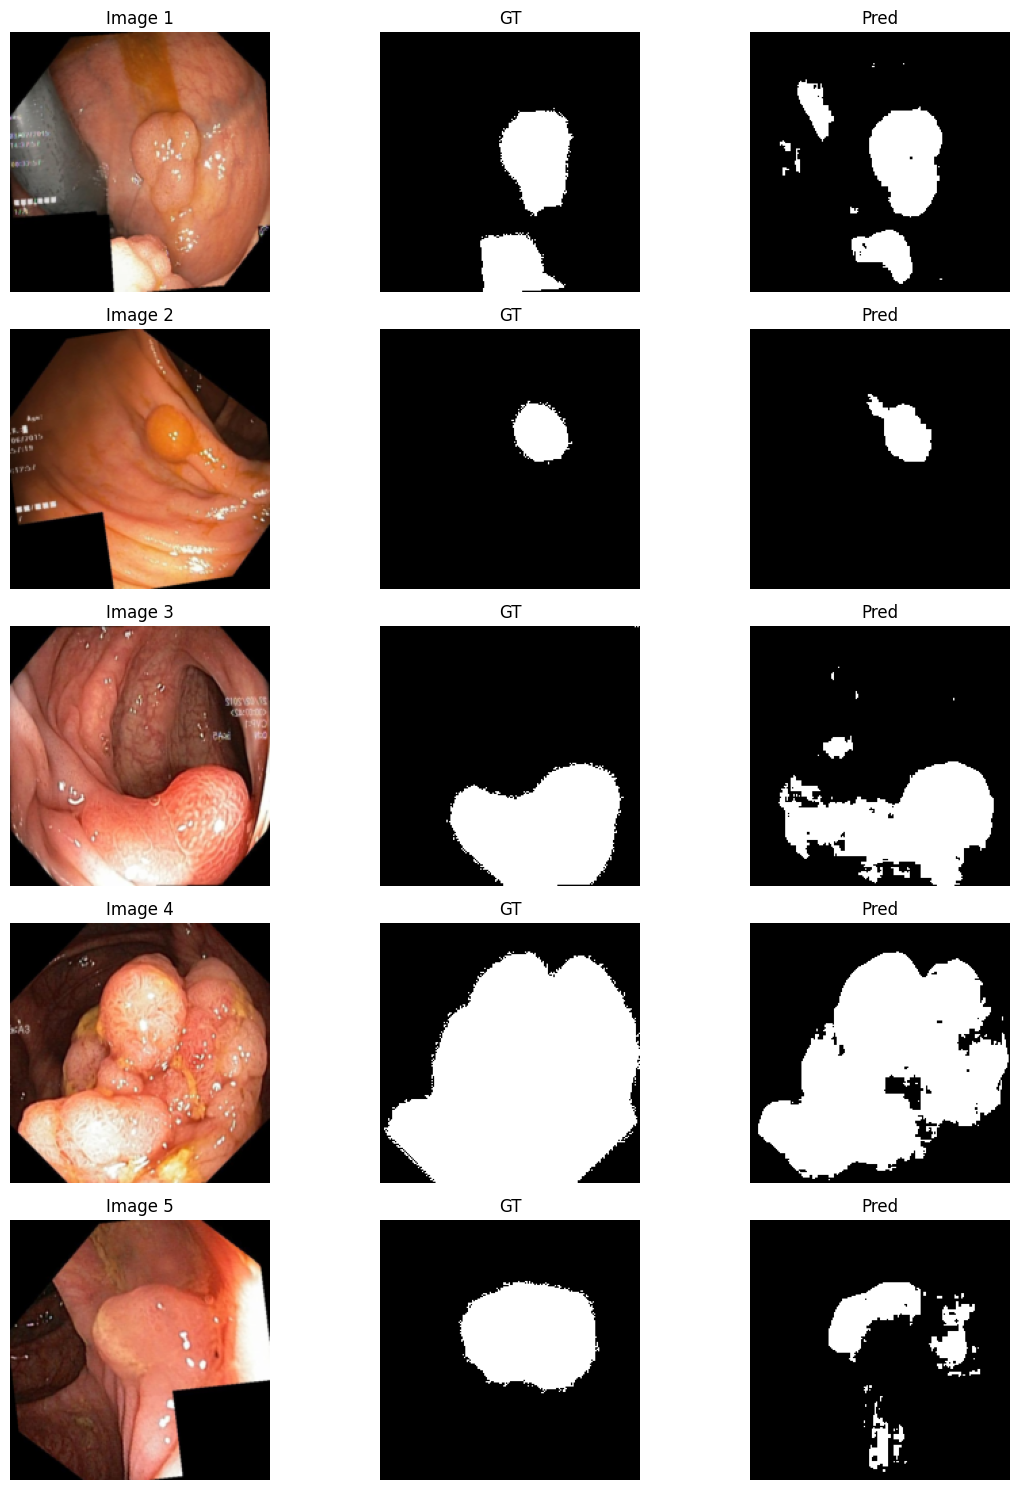

In [ ]:
# ---------------- training loop with early stopping ----------------
best_iou = -1.0
best_epoch = -1
best_state = None
train_losses = []
val_losses = []
val_ious = []
val_dices = []
stalled = 0

start = time.time()
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(DEVICE); masks = masks.to(DEVICE)
        logits = model(imgs)
        loss = 0.5*bce(logits, masks) + 0.5*dice_loss_logits(logits, masks)
        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()
        running_loss += float(loss.item()) * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    running_val_loss = 0.0
    accum_dice = []; accum_iou = []; total_valid = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(DEVICE); masks = masks.to(DEVICE)
            logits = model(imgs)
            running_val_loss += float(bce(logits, masks).item()) * imgs.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs > THRESH).float()
            d,i,n = batch_dice_iou(preds, masks)
            if n>0:
                accum_dice.append((d,n)); accum_iou.append((i,n)); total_valid += n

    val_loss = running_val_loss / len(val_loader.dataset)
    if total_valid > 0:
        mean_dice = sum([d*n for d,n in accum_dice]) / total_valid
        mean_iou  = sum([i*n for i,n in accum_iou]) / total_valid
    else:
        mean_dice = float('nan'); mean_iou = float('nan')

    val_losses.append(val_loss); val_dices.append(mean_dice); val_ious.append(mean_iou)
    print(f"Epoch {epoch}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  Dice={mean_dice:.4f}  IoU={mean_iou:.4f}  valid={total_valid}")

    if not np.isnan(mean_iou):
        scheduler.step(mean_iou)
    if not np.isnan(mean_iou) and mean_iou > best_iou + 1e-4:
        best_iou = mean_iou
        best_epoch = epoch
        best_state = model.state_dict()
        stalled = 0
        torch.save(best_state, "best_unet_kvasir.pth")
        print(f"  -> saved best model (IoU={best_iou:.4f})")
    else:
        stalled += 1
        if stalled >= PATIENCE:
            print(f"Early stopping: no improvement for {PATIENCE} epochs.")
            break

end = time.time()
print(f"Training finished in {(end-start)/60:.2f} min. Best IoU={best_iou:.4f} at epoch {best_epoch}")

# ---------------- show best sample prediction ----------------
# ---------------- show top 5 validation predictions ----------------
if best_state is None:
    print("No saved model (no valid IoU). Exiting.")
else:
    model.load_state_dict(best_state)
    model.eval()

    num_to_show = min(5, len(val_ds))
    print(f"Best epoch: {best_epoch}, Best IoU: {best_iou:.4f}")
    print(f"Showing top {num_to_show} validation predictions:")

    plt.figure(figsize=(12, num_to_show * 3))
    for i in range(num_to_show):
        sample_img, sample_mask = val_ds[i]
        with torch.no_grad():
            logits = model(sample_img.unsqueeze(0).to(DEVICE))
            probs = torch.sigmoid(logits)
            pred = (probs > THRESH).float()[0].cpu()

        img_np = sample_img.permute(1, 2, 0).numpy()
        # unnormalize the image (undo normalization)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(num_to_show, 3, 3 * i + 1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"Image {i+1}")

        plt.subplot(num_to_show, 3, 3 * i + 2)
        plt.imshow(sample_mask.squeeze(0).numpy(), cmap='gray')
        plt.axis('off')
        plt.title("GT")

        plt.subplot(num_to_show, 3, 3 * i + 3)
        plt.imshow(pred.squeeze(0).numpy(), cmap='gray')
        plt.axis('off')
        plt.title("Pred")

    plt.tight_layout()
    plt.show()

